In [101]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import pandoc

import warnings
warnings.filterwarnings('ignore')

#Perform EDA

In [2]:
data = pd.read_csv('~/Downloads/insurance.csv')
data.shape

(1338, 7)

In [3]:
#show first five rows of data
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
#check missing values
data.isnull().values.any()

False

In [5]:
numerical = data[['age','bmi','children','charges']]
categorical = data[['sex','region','smoker']]

In [6]:
#show summary statistics of numerical data and truncate the displayed data to 3 for better showing
numerical = data[['age','bmi','children','charges']]
pd.set_option("display.precision", 3)
numerical.describe()

,age,bmi,children,charges
count,1338.000,1338.000,1338.000,1338.000
mean,39.207,30.663,1.095,13270.422
std,14.050,6.098,1.205,12110.011
min,18.000,15.960,0.000,1121.874
25%,27.000,26.296,0.000,4740.287
50%,39.000,30.400,1.000,9382.033
75%,51.000,34.694,2.000,16639.913
max,64.000,53.130,5.000,63770.428


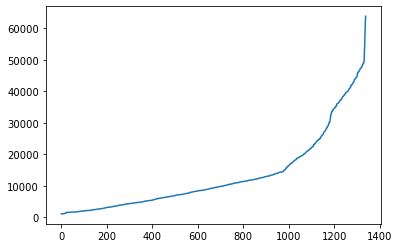

In [7]:
#display y
plt.plot(sorted(data['charges']))

We can see from this plot that charges follow the exponential distribution, so next step we can try to do the log-transformation

In [8]:
data['charges'] = np.log(data['charges'])

Display Categorical data

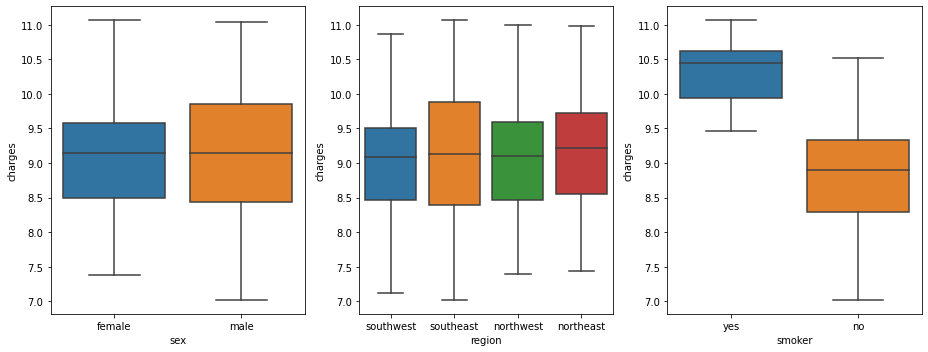

In [83]:
fig = plt.figure(figsize=(13,5))

ax1 = fig.add_subplot(131)
sns.boxplot(ax=ax1,data=data, x="sex", y="charges")

ax2 = fig.add_subplot(132)
sns.boxplot(data=data, x="region", y="charges",ax=ax2)

ax3 = fig.add_subplot(133)
sns.boxplot(ax=ax3,data=data, x="smoker", y="charges")

plt.tight_layout()

Sex:
the insurance charges of female is more concentrated than male, however its minimum and maximum charge are both higher than male

Region:
The difference across regions is not really obvious, which the charge of people live in the southeast is less concentrated that other regions.

Smoker:
People who smoke normally are charged higher than people who dont, since its medium is amolst equal to the maximum of non-smokers.

<AxesSubplot:title={'center':'Correlation Matrix'}>

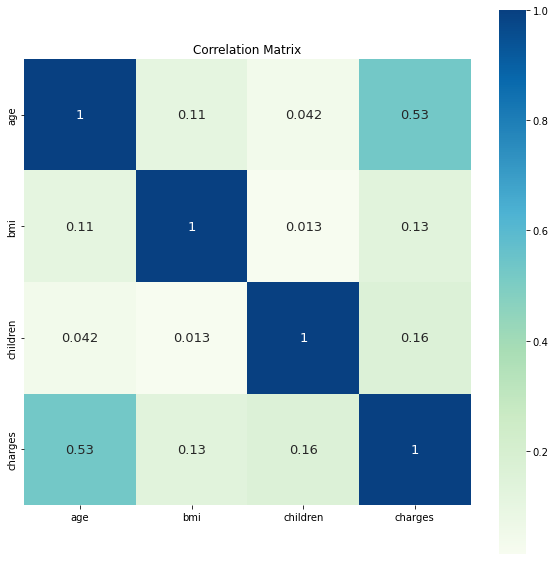

In [98]:
correlation = data.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='GnBu',annot_kws={"fontsize":13})

Age have some correlation with bmi (0.11) but not really large and have observable correlations (0.53) with insurance charges which is the main thing that we are interested in.
BMI and Children show some correlation with insurance charge (0.13 and 0.16), but not really large.
Thus, there is not obvious sign of multi-colinearity, so the method with regularization may not perform better than simple linear regression but we will check that in the step of modelling.

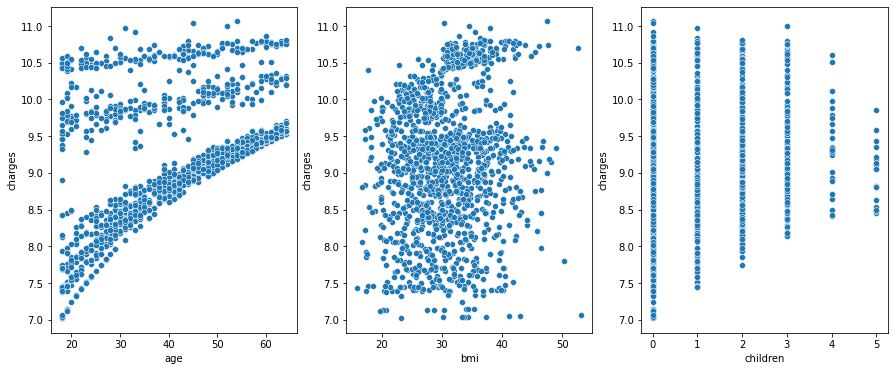

In [92]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(131)
sns.scatterplot(ax=ax1, data=data, x="age", y="charges")

ax2 = fig.add_subplot(132)
sns.scatterplot(ax=ax2, data=data, x="bmi", y="charges")

ax3 = fig.add_subplot(133)
sns.scatterplot(ax=ax3, data=data, x="children", y="charges")

plt.show()

Age:
This plot shows clear positive trend, which means if the person is older, charge is higher

BMI:
BMI plot does not show clear linear relationship with charges.

Children:
Children shows trend that the charges of people who have more children are more concentrated and have smaller variance than people who have less children. However, this relationship is not linear thus the linear correlation between children and charges shown in the correlation matrix is not really large, but it does not mean they do not have significant correlation. So the linear regression may not the best model to predict the charge using these predictors but we will check that in the step of modelling.

Train Test Split

In [15]:
validation_size = 0.2
seed = 9
X = data.loc[:, data.columns != 'charges']
Y = data['charges']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#Data Preprocessing

convert categorical data to numerical (one-hot encoding) and remove one of them for reducing multi-collinearity

In [16]:
X_train = pd.concat([X_train,pd.get_dummies(X_train.sex, prefix='sex').iloc[:,1:]],axis=1)
X_train = pd.concat([X_train,pd.get_dummies(X_train.region, prefix='region').iloc[:,1:]],axis=1)
X_train = pd.concat([X_train,pd.get_dummies(X_train.smoker, prefix='smoker').iloc[:,1:]],axis=1)
#delete original categorical column
del X_train['sex']
del X_train['region']
del X_train['smoker']
X_train = X_train.rename(columns={"sex_male": "sex"})
X_train =X_train.rename(columns={"smoker_yes": "smoker"})
#Then for one sample, if its sex is indicated as 1, then it is a male or its a female.
#Then for one sample, if its smoker is indicated as 1, then it is a smoker or its not.
X_train.head()

,age,bmi,children,sex,region_northwest,region_southeast,region_southwest,smoker
333,56,28.785,0,0,0,0,0,0
644,43,35.310,2,1,0,1,0,0
1134,28,33.820,0,1,1,0,0,0
852,46,35.530,0,0,0,0,0,1
514,39,28.300,1,1,0,0,1,1


In [17]:
X_validation = pd.concat([X_validation,pd.get_dummies(X_validation.sex, prefix='sex').iloc[:,1:]],axis=1)
X_validation = pd.concat([X_validation,pd.get_dummies(X_validation.region, prefix='region').iloc[:,1:]],axis=1)
X_validation = pd.concat([X_validation,pd.get_dummies(X_validation.smoker, prefix='smoker').iloc[:,1:]],axis=1)
#delete original categorical column
del X_validation['sex']
del X_validation['region']
del X_validation['smoker']
X_validation = X_validation.rename(columns={"sex_male": "sex"})
X_validation =X_validation.rename(columns={"smoker_yes": "smoker"})
#Then for one sample, if its sex is indicated as 1, then it is a male or its a female.
#Then for one sample, if its smoker is indicated as 1, then it is a smoker or its not.
X_validation.head()

,age,bmi,children,sex,region_northwest,region_southeast,region_southwest,smoker
227,58,41.910,0,0,0,1,0,0
1235,26,31.065,0,1,1,0,0,0
985,44,25.800,1,0,0,0,1,0
326,27,23.210,1,0,0,1,0,0
352,30,27.700,0,0,0,0,1,0


Standardization

In [18]:
X_train['age'] = (X_train['age']-X_train['age'].mean())/X_train['age'].std()
X_train['bmi'] = (X_train['bmi']-X_train['bmi'].mean())/X_train['bmi'].std()

X_validation['age'] = (X_validation['age']-X_validation['age'].mean())/X_validation['age'].std()
X_validation['bmi'] = (X_validation['bmi']-X_validation['bmi'].mean())/X_validation['bmi'].std()

#Building Models

In [112]:
parametersLR = [{'n_features_to_select': list(range(1, 14))}]
parametersLASSO = {'alpha':[0.1,0.2,0.5,0.7,1.0,2.0], 'max_iter':[300,500,1000,2000],'tol':[0.0001,0.00001,0.000001,0.0000001],
                   'selection':['random','cyclic']}
parametersEN = {'alpha':[0.1,0.2,0.5,0.7,1.0,2.0],'l1_ratio':[0.1,0.2,0.5,0.7], 'max_iter':[300,500,1000,2000,2500],
               'tol':[0.0001,0.00001,0.000001],'selection':['random','cyclic']}
parametersKNN = {'n_neighbors':[5,7,10,15], 'weights':['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree','brute'],
                'leaf_size':[20,25,30,35],'p':[1,2,3,5]}
parametersDTree = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'splitter':['best','random']}
parametersSVR = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[2,3,4,5],'gamma':['scale','auto'],
                          'coef0':[0.0,0.1,0.2,0.5],'tol':[0.01,0.001,0.0001],'C':[1.0,2.0,3.0],'epsilon':[0.1,0.2,0.3]}

Do gridsearch to find the best set of parameters

In [113]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
names = ['LR','LASSO','EN','KNN','DTree','SVR']
mse = list()
rmse = list()
mae = list()
print()
lr = LinearRegression()
resLR = lr.fit(X_train, Y_train)
mseLr = round(mean_squared_error(Y_validation, resLR.predict(X_validation),squared=True),5)
rmseLr = round(mean_squared_error(Y_validation, resLR.predict(X_validation),squared=False),5)
maeLr = round(mean_absolute_error(Y_validation, resLR.predict(X_validation)),5)
print("LinearRegression MSE: %s"%(mseLr))
print("LinearRegression Root MSE: %s"%(rmseLr))
print("LinearRegression MAE: %s"%(maeLr))
mse.append(mseLr)
rmse.append(rmseLr)
mae.append(maeLr)
print('---------------------------------')
print()
lasso = GridSearchCV(Lasso(), parametersLASSO,scoring='neg_root_mean_squared_error')
lasso.fit(X_train, Y_train)
mseLasso = round(mean_squared_error(Y_validation, lasso.predict(X_validation),squared=True),5)
rmseLasso = round(mean_squared_error(Y_validation, lasso.predict(X_validation),squared=False),5)
maeLasso = round(mean_absolute_error(Y_validation, lasso.predict(X_validation)),5)
print("Lasso Best Parameter: %s"%(lasso.best_params_))
print("Lasso MSE: %s"%(mseLasso))
print("Lasso Root MSE: %s"%(rmseLasso))
print("Lasso MAE: %s"%(maeLasso))
mse.append(mseLasso)
rmse.append(rmseLasso)
mae.append(maeLasso)
print('---------------------------------')
print()
en = GridSearchCV(ElasticNet(), parametersEN,scoring='neg_root_mean_squared_error')
en.fit(X_train, Y_train)
mseEN = round(mean_squared_error(Y_validation, en.predict(X_validation),squared=True),5)
rmseEN = round(mean_squared_error(Y_validation, en.predict(X_validation),squared=False),5)
maeEN = round(mean_absolute_error(Y_validation, en.predict(X_validation)),5)
print("ElasticNet Best Parameter: %s"%(en.best_params_))
print("ElasticNet MSE: %s"%(mseEN))
print("ElasticNet Root MSE: %s"%(rmseEN))
print("ElasticNet MAE: %s"%(maeEN))
mse.append(mseEN)
rmse.append(rmseEN)
mae.append(maeEN)
print('---------------------------------')
print()
knn = GridSearchCV(KNeighborsRegressor(), parametersKNN,scoring='neg_root_mean_squared_error')
knn.fit(X_train, Y_train)
mseKNN = round(mean_squared_error(Y_validation, knn.predict(X_validation),squared=True),5)
rmseKNN = round(mean_squared_error(Y_validation, knn.predict(X_validation),squared=False),5)
maeKNN = round(mean_absolute_error(Y_validation, knn.predict(X_validation)),5)
print("KNN Best Parameter: %s"%(knn.best_params_))
print("KNN MSE: %s"%(mseKNN))
print("KNN Root MSE: %s"%(rmseEN))
print("KNN MAE: %s"%(maeEN))
mse.append(mseKNN)
rmse.append(rmseKNN)
mae.append(maeKNN)
print('---------------------------------')
print()
dt = GridSearchCV(DecisionTreeRegressor(), parametersDTree,scoring='neg_root_mean_squared_error')
dt.fit(X_train, Y_train)
mseDTree = round(mean_squared_error(Y_validation, dt.predict(X_validation),squared=True),5)
rmseDTree = round(mean_squared_error(Y_validation, dt.predict(X_validation),squared=False),5)
maeDTree = round(mean_absolute_error(Y_validation, dt.predict(X_validation)),5)
print("Decision Tree Best Parameter: %s"%(dt.best_params_))
print("Decision Tree MSE: %s"%(mseDTree))
print("Decision Tree Root MSE: %s"%(rmseDTree))
print("Decision Tree MAE: %s"%(maeDTree))
mse.append(mseDTree)
rmse.append(rmseDTree)
mae.append(maeDTree)
print('---------------------------------')
print()
svr = GridSearchCV(SVR(), parametersSVR,scoring='neg_root_mean_squared_error')
svr.fit(X_train, Y_train)
mseSVR = round(mean_squared_error(Y_validation, svr.predict(X_validation),squared=True),5)
rmseSVR = round(mean_squared_error(Y_validation, svr.predict(X_validation),squared=False),5)
maeSVR = round(mean_absolute_error(Y_validation, svr.predict(X_validation)),5)
print("SVR Best Parameter: %s"%(svr.best_params_))
print("SVR MSE: %s"%(mseSVR))
print("SVR Root MSE: %s"%(rmseSVR))
print("SVR MAE: %s"%(maeSVR))
mse.append(mseSVR)
rmse.append(rmseSVR)
mae.append(maeSVR)


LinearRegression MSE: 0.17958
LinearRegression Root MSE: 0.42377
LinearRegression MAE: 0.25593
---------------------------------

Lasso Best Parameter: {'alpha': 0.1, 'max_iter': 2000, 'selection': 'random', 'tol': 0.0001}
Lasso MSE: 0.27003
Lasso Root MSE: 0.51964
Lasso MAE: 0.34339
---------------------------------

ElasticNet Best Parameter: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 300, 'selection': 'random', 'tol': 0.0001}
ElasticNet MSE: 0.24943
ElasticNet Root MSE: 0.49943
ElasticNet MAE: 0.33596
---------------------------------

KNN Best Parameter: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
KNN MSE: 0.19953
KNN Root MSE: 0.49943
KNN MAE: 0.33596
---------------------------------

Decision Tree Best Parameter: {'criterion': 'absolute_error', 'splitter': 'best'}
Decision Tree MSE: 0.27403
Decision Tree Root MSE: 0.52348
Decision Tree MAE: 0.24745
---------------------------------

SVR Best Parameter: {'C': 2.0, 'coef0': 0.5, 'degr

I decide to choose Root MSE as the final metric. I choose Root MSE over MSE because its unit is same as as charge (dollar) which make sense, not squared unit (squared dollar) if we use MSE. I choose Root MSE over MAE because MSE and RMSE punish larger errors more than smaller errors however MAE does not give more or less weight to different types of errors and instead the scores increase linearly with increases in error.

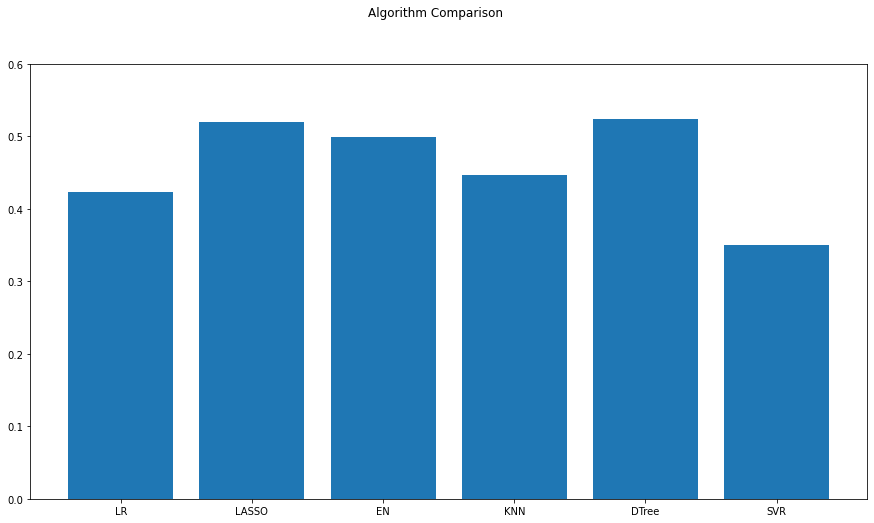

In [114]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(x=names,height=rmse)
ax.set_xticklabels(names)
ax.set_ylim([0,0.6])
fig.set_size_inches(15,8)
plt.show()

We can see from the above plot that SVR model can return the smallest RMSE, thus we will choose this model as the final one. And the regulization methods does not perform better than linear regression model, and linear regression model is not the best one, which are all same as what we guess in the part of EDA.

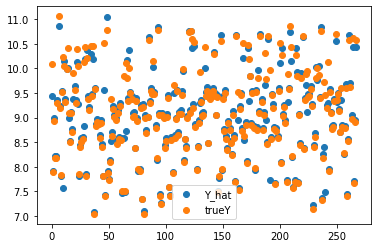

In [115]:
#Y_predicted = svr.predict(X_validation)
Y_predictedD = pd.DataFrame(Y_predicted)
Y_validationD = pd.DataFrame(Y_validation)
plt.scatter(x=Y_predictedD.index, y=list(Y_predicted), label = "Y_hat")
plt.scatter(x=Y_predictedD.index,y=Y_validation, label = "trueY")
plt.legend()
plt.show()

From the above figure, we can see that if we use SVR as the prediction model, the predicted y is almost located at the same position as the real y. This also shows that the model we choose is not bad.